# <u>**Streaming Service Comparison**</u>

### **Objective:**
- Determine which streaming platform hosts the majority of content I enjoy so that I can pare down the services to which I subscribe. 

### **Data Sources:**
- [Netflix via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-netflix-dataset)
- [Hulu via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-hulu-dataset)
- [Prime via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-amazon-prime-dataset/data)
- [AppleTV via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-apple-tv-dataset)

## **Data Collection & Loading**

### **Import Pandas, Numpy, Matplotlib, Wordcloud, and PIL**

In [23]:
import glob
import pandas as pd
import os
import numpy as np
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sn
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

### **Data Load**

In [24]:
# Load in each file separately. 
apple = pd.read_csv("Data/AppleTV.csv")
hulu = pd.read_csv("Data/Hulu.csv")
netflix = pd.read_csv("Data/Netflix.csv")
prime = pd.read_csv("Data/Prime.csv")

### **Preliminary Review**

In [25]:
# View the head of each dataframe 
# Create a variable to include a list of all dataframes recently imported
dataframes = [apple, hulu, netflix, prime]
# Display only the head of each dataframe separately
for df in dataframes:
    display(df.head())

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN
1,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN
2,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1241156.0,NaN
3,Citizen Kane,movie,"Drama, Mystery",1941.0,tt0033467,8.3,478085.0,NaN
4,Metropolis,movie,"Drama, Sci-Fi",1927.0,tt0017136,8.3,192628.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.5,7792.0,NaN
2,Finding Nemo,movie,"Adventure, Animation, Comedy",2003.0,tt0266543,8.2,1149529.0,NaN
3,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN
4,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,522699.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1241156.0,NaN
1,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,522699.0,NaN
2,Kill Bill: Vol. 1,movie,"Action, Crime, Thriller",2003.0,tt0266697,8.2,1238778.0,NaN
3,Jarhead,movie,"Biography, Drama, War",2005.0,tt0418763,7.0,214024.0,NaN
4,Unforgiven,movie,"Drama, Western",1992.0,tt0105695,8.2,449594.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN
1,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN
2,Judgment Night,movie,"Action, Crime, Drama",1993.0,tt0107286,6.6,19686.0,NaN
3,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN
4,Citizen Kane,movie,"Drama, Mystery",1941.0,tt0033467,8.3,478085.0,NaN


In [26]:
# Get a sum of the total row count from each dataframe
total_rows = len(apple) + len(hulu) + len(netflix) + len(prime)
print(f"The total row count is {total_rows} for all dataframes.")

The total row count is 119711 for all dataframes.


### **Initial Insights**
- There are a total of 119,711 among all raw dataframes
- Each dataframe contains the same column headings
- None of the dataframes contain a column for the source of the dataframe
- All numerical columns appear to be floats and don't need to be
    - Change ***releaseYear*** and ***imdbNumVotes*** to integers
- The majority of the titles displayed contain multiple genres in the ***genres*** column
- The ***imdbId*** columns appear to match 
    - *American Beauty* in the 1st and 3rd dataframe
    - *Forest Gump* in the 1st, 2nd and 4th dataframes
- Of all the rows displayed, none include ***availableCountries*** data
    - Further information proves that this data point is not prevelent throughout the four dataframes


### **Preliminary Data Manipulation**

In [27]:
# Add a column to each dataframe to identify the data source since individually they do not have an identifier. 
# This is to ensure the data is discernable after the merge when duplicate content is present
apple["Service_Name"] = "AppleTV"
hulu["Service_Name"] = "Hulu"
netflix["Service_Name"] = "Netflix"
prime["Service_Name"] = "Prime"

# Using a previously made variable, created a for loop to run through each dataframe and out a display of only the first two rows 
# This is to ensure the column names and values were added propertly
for df in dataframes:
    display(df.head(2))

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN,AppleTV
1,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN,AppleTV


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN,Hulu
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.5,7792.0,NaN,Hulu


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1241156.0,NaN,Netflix
1,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,522699.0,NaN,Netflix


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN,Prime
1,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN,Prime


### **Data Merge**

In [28]:
# Merge the dataframes together into one by appending them to the end of each other since they are all using the same column names
streaming_v1 = pd.concat([apple, hulu, netflix, prime], axis = 0)
# Based on above initial review, check to ensure there are a total of 119,711 rows in the new dataframe
streaming_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119711 entries, 0 to 70293
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   title               116151 non-null  object 
 1   type                119711 non-null  object 
 2   genres              116226 non-null  object 
 3   releaseYear         119419 non-null  float64
 4   imdbId              109192 non-null  object 
 5   imdbAverageRating   105942 non-null  float64
 6   imdbNumVotes        105942 non-null  float64
 7   availableCountries  651 non-null     object 
 8   Service_Name        119711 non-null  object 
dtypes: float64(3), object(6)
memory usage: 9.1+ MB


### **Data Cleaning & Preparation**

In [29]:
# Drop the availableCountries column given that less than 1% (0.0054%) of entries utilize this data element
streaming_v1.drop("availableCountries", axis = 1, inplace=True)
# Display only the columns to ensure the dropped column is gone
streaming_v1.columns

Index(['title', 'type', 'genres', 'releaseYear', 'imdbId', 'imdbAverageRating',
       'imdbNumVotes', 'Service_Name'],
      dtype='object')

In [30]:
# Rename the columns 
streaming_v1.rename(columns={"title":"Title","type":"Content_Type","genres":"Combined_Genres","releaseYear":"Release_Year","imdbId":"IMDb_ID","imdbAverageRating":"IMDb_Avg_Rating","imdbNumVotes":"IMDb_Votes_Count"},inplace = True)
streaming_v1.columns


Index(['Title', 'Content_Type', 'Combined_Genres', 'Release_Year', 'IMDb_ID',
       'IMDb_Avg_Rating', 'IMDb_Votes_Count', 'Service_Name'],
      dtype='object')

In [31]:
# Change Release_Year, IMDb_Votes_Counts from floats to integers 
streaming_v1[["Release_Year","IMDb_Votes_Count"]] = streaming_v1[["Release_Year","IMDb_Votes_Count"]].apply(np.int64)

# Display only the data types to ensure the data types were changed
streaming_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119711 entries, 0 to 70293
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116151 non-null  object 
 1   Content_Type      119711 non-null  object 
 2   Combined_Genres   116226 non-null  object 
 3   Release_Year      119711 non-null  int64  
 4   IMDb_ID           109192 non-null  object 
 5   IMDb_Avg_Rating   105942 non-null  float64
 6   IMDb_Votes_Count  119711 non-null  int64  
 7   Service_Name      119711 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 8.2+ MB


c:\Users\rkynhoff\OneDrive - University of Rochester\Documents\CodeLouisville\Streaming_Service_Comparisons\venv\Lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [32]:
# Determine how many titles contain null values
print("There are",streaming_v1["Title"].isna().sum(),"rows with null values in the Title column.")

There are 3560 rows with null values in the Title column.


In [33]:
# Drop the rows containing null values in the Title column
streaming_v1 = streaming_v1.dropna(subset=["Title"])
# Ensure duplicate rows were dropped
streaming_v1.info()
# Can see in the infor results that the total entries went from 119,711 to 116,151, a drop of 3,560 rows


<class 'pandas.core.frame.DataFrame'>
Index: 116151 entries, 0 to 70293
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116151 non-null  object 
 1   Content_Type      116151 non-null  object 
 2   Combined_Genres   113936 non-null  object 
 3   Release_Year      116151 non-null  int64  
 4   IMDb_ID           109192 non-null  object 
 5   IMDb_Avg_Rating   105942 non-null  float64
 6   IMDb_Votes_Count  116151 non-null  int64  
 7   Service_Name      116151 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 8.0+ MB


In [34]:
# Determine how man rows include null values for Comebined_Genres
print("There are",streaming_v1["Combined_Genres"].isna().sum(),"rows with null values in the Combined_Genres column.")

There are 2215 rows with null values in the Combined_Genres column.


In [35]:
# Determine how many duplicated rows exist
print("There are", streaming_v1.duplicated().sum(),"duplicated rows.")

There are 8 duplicated rows.


In [36]:
# Taking a look at the duplicated rows since there are so few & sort by title alphabetically with the default ascending
streaming_v1[streaming_v1.duplicated(keep=False)].sort_values("Title")

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
3486,A Personal Journey with Martin Scorsese Throug...,movie,"Biography, Documentary, History",1995,tt0112120,8.5,5201,AppleTV
13979,A Personal Journey with Martin Scorsese Throug...,movie,"Biography, Documentary, History",1995,tt0112120,8.5,5201,AppleTV
36061,Belle,movie,"Fantasy, Horror",2023,tt12373754,5.4,169,Prime
45434,Belle,movie,"Fantasy, Horror",2023,tt12373754,5.4,169,Prime
25222,Burn,movie,NaN,2014,NaN,NaN,-9223372036854775808,Prime
42998,Burn,movie,NaN,2014,NaN,NaN,-9223372036854775808,Prime
50643,Flower Boy,movie,NaN,2021,NaN,NaN,-9223372036854775808,Prime
51439,Flower Boy,movie,NaN,2021,NaN,NaN,-9223372036854775808,Prime
7245,Scorned: Love Kills,tv,"Crime, Documentary",2012,tt2287041,6.9,304,Hulu
7246,Scorned: Love Kills,tv,"Crime, Documentary",2012,tt2287041,6.9,304,Hulu


In [37]:
# Since the rows do appear to be fully dupliated, I will drop the duplicate rows here
streaming_v2 = streaming_v1.drop_duplicates()
# Reset the index
streaming_v2 = streaming_v2.reset_index(drop=True)
streaming_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116143 entries, 0 to 116142
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116143 non-null  object 
 1   Content_Type      116143 non-null  object 
 2   Combined_Genres   113930 non-null  object 
 3   Release_Year      116143 non-null  int64  
 4   IMDb_ID           109187 non-null  object 
 5   IMDb_Avg_Rating   105937 non-null  float64
 6   IMDb_Votes_Count  116143 non-null  int64  
 7   Service_Name      116143 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 7.1+ MB


In [38]:
# Determine how many rows have null values. Will revisit this later.
streaming_v1.loc[streaming_v1["Combined_Genres"].isnull()]

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
2008,Anthappuram,movie,NaN,1980,tt0315778,5.6,7,AppleTV
3011,Siste trikk,movie,NaN,2024,NaN,NaN,-9223372036854775808,AppleTV
3082,Breathe without Water,movie,NaN,2024,NaN,NaN,-9223372036854775808,AppleTV
3088,El Arte De La Guerra,movie,NaN,2024,NaN,NaN,-9223372036854775808,AppleTV
3499,Atze Schröder - Revolution,movie,NaN,2010,NaN,NaN,-9223372036854775808,AppleTV
...,...,...,...,...,...,...,...,...
68120,Shea-suru ra! Instanto râmen arenji bu hajimem...,tv,NaN,2022,tt19408810,NaN,-9223372036854775808,Prime
68697,Secrets of the Exhibit,tv,NaN,2015,tt14546892,NaN,-9223372036854775808,Prime
68964,Hee!Hee!Hoo!,tv,NaN,2023,tt27010738,NaN,-9223372036854775808,Prime
69551,Kusuburi onna to sundome onna,tv,NaN,2023,tt29471798,NaN,-9223372036854775808,Prime


In [39]:
# Now that duplicated rows are gone, I want to see if there might be duplicated content baesd on IMDb_ID, Release_Year, Title, Content_Type, and Service Name
streaming_v2[streaming_v2.duplicated(subset = ["IMDb_ID","Title","Release_Year","Content_Type","Service_Name"], keep = False)].sort_values(by=["Title","Service_Name","Combined_Genres"], ascending=[True,True,True])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
38236,Amr's in Trouble,movie,"Romance, Comedy",2019,NaN,NaN,-9223372036854775808,Netflix
41702,Amr's in Trouble,movie,NaN,2019,NaN,NaN,-9223372036854775808,Netflix
93066,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime
92157,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime
13328,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,AppleTV
13557,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,AppleTV
42322,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Netflix
42627,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Netflix
105044,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime
106211,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime


In [40]:
# Based on the output above, I can see there is duplicated content and rows where genres could be combined into one row for each Service_Name

# Remove the duplicated rows that have a null value in the Combined_Genres column by index number
streaming_v3 = streaming_v2.drop([41702,12177,37721,89252,108129,108076,40887,102086,107404])
# Reset index
streaming_v3 = streaming_v3.reset_index(drop=True)
# Double check
streaming_v3[streaming_v3["Title"] == "The Final Ride"]


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
87483,The Final Ride,movie,"Comedy, Horror",2019,tt9869668,5.4,83,Prime
103850,The Final Ride,movie,"Crime, Action",2021,NaN,NaN,-9223372036854775808,Prime


In [41]:
# Redisplay the duplicated content baesd on IMDb_ID, Release_Year, Title, Content_Type, and Service Name

grouped_dupes = streaming_v3[streaming_v3.duplicated(subset = ["IMDb_ID","Title","Release_Year","Content_Type","Service_Name"], keep = False)].sort_values(by=["Title","Service_Name","Combined_Genres"], ascending=[True,True,True])
grouped_dupes

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
93061,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime
92152,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime
13327,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,AppleTV
13556,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,AppleTV
42318,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Netflix
42623,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Netflix
105038,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime
106205,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime
106324,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Prime
103994,Fences,movie,Documentary,2023,NaN,NaN,-9223372036854775808,Prime


In [42]:
concatenated_genres = {}
for index, row in grouped_dupes.iterrows():
    key = (row["Title"], row["Content_Type"],row["Release_Year"], row["IMDb_ID"], row["IMDb_Votes_Count"], row["Service_Name"])
    if key in concatenated_genres:
        concatenated_genres[key] += row["Combined_Genres"] + ', '
    else:
        concatenated_genres[key] = row["Combined_Genres"] + ', '

result_data = []
for key, genres in concatenated_genres.items():
    result_data.append([key[0], key[1],genres[:-2], key[2], key[3], key[4], key[5]])

result_df = pd.DataFrame(result_data, columns = ["Title","Content_Type","Combined_Genres","Release_Year","IMDb_ID","IMDb_Votes_Count","Service_Name"])
result_df["IMDb_Avg_Rating"] = "None"
column_titles = ["Title","Content_Type","Combined_Genres","Release_Year","IMDb_ID","IMDb_Avg_Rating","IMDb_Votes_Count","Service_Name"]
result_df = result_df.reindex(columns=column_titles)
result_df

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
0,Aurora,movie,"Animation, Horror",2019,NaN,None,-9223372036854775808,Prime
1,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,AppleTV
2,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,Netflix
3,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,Prime
4,Fences,movie,"Comedy, Drama, Documentary",2023,NaN,None,-9223372036854775808,Prime
5,Imago,movie,"Drama, Thriller, Horror",2024,NaN,None,-9223372036854775808,Prime
6,Leonardo: The Man Who Saved Science,movie,"Documentary, History, Documentary, History, TV...",2017,NaN,None,-9223372036854775808,Prime
7,Stealing Chaplin,movie,"Comedy, Drama, Comedy, History",2024,NaN,None,-9223372036854775808,Prime
8,When life gives you lemons,movie,"Animation, Music",2024,NaN,None,-9223372036854775808,Prime


In [43]:
streaming_v4 = pd.concat([streaming_v3,result_df], axis = 0)

In [44]:
streaming_v4[streaming_v4["Title"] == "The Final Ride"]

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
87483,The Final Ride,movie,"Comedy, Horror",2019,tt9869668,5.4,83,Prime
103850,The Final Ride,movie,"Crime, Action",2021,NaN,NaN,-9223372036854775808,Prime


In [45]:
streaming_v4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116143 entries, 0 to 8
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Title             116143 non-null  object
 1   Content_Type      116143 non-null  object
 2   Combined_Genres   113939 non-null  object
 3   Release_Year      116143 non-null  int64 
 4   IMDb_ID           109187 non-null  object
 5   IMDb_Avg_Rating   105946 non-null  object
 6   IMDb_Votes_Count  116143 non-null  int64 
 7   Service_Name      116143 non-null  object
dtypes: int64(2), object(6)
memory usage: 8.0+ MB


In [46]:
#Obtain max number of elements in the Genres column
streaming_v4["Combined_Genres"].str.split(", ",expand=True)


,0,1,2,3,4,5,6
0,Comedy,None,None,None,None,None,None
1,Drama,Romance,None,None,None,None,None
2,Drama,None,None,None,None,None,None
3,Drama,Mystery,None,None,None,None,None
4,Drama,Sci-Fi,None,None,None,None,None
...,...,...,...,...,...,...,...
4,Comedy,Drama,Documentary,None,None,None,None
5,Drama,Thriller,Horror,None,None,None,None
6,Documentary,History,Documentary,History,TV Movie,None,None
7,Comedy,Drama,Comedy,History,None,None,None


In [47]:
# Split the elements in the Genres column while creating new columns for the max number 
streaming_v4[["Genre_1","Genre_2","Genre_3","Genre_4","Genre_5","Genre_6","Genre_7"]] = streaming_v4["Combined_Genres"].str.split(',',expand=True)

streaming_v4.head(2)

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7
0,Four Rooms,movie,Comedy,1995,tt0113101,6.7,113546,AppleTV,Comedy,None,None,None,None,None,None
1,Forrest Gump,movie,"Drama, Romance",1994,tt0109830,8.8,2354158,AppleTV,Drama,Romance,None,None,None,None,None


In [48]:
# Creating clean dataframe
streaming_clean = streaming_v4

### **Begin Analysis**

In [49]:
streaming_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116143 entries, 0 to 8
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Title             116143 non-null  object
 1   Content_Type      116143 non-null  object
 2   Combined_Genres   113939 non-null  object
 3   Release_Year      116143 non-null  int64 
 4   IMDb_ID           109187 non-null  object
 5   IMDb_Avg_Rating   105946 non-null  object
 6   IMDb_Votes_Count  116143 non-null  int64 
 7   Service_Name      116143 non-null  object
 8   Genre_1           113939 non-null  object
 9   Genre_2           75987 non-null   object
 10  Genre_3           44389 non-null   object
 11  Genre_4           117 non-null     object
 12  Genre_5           27 non-null      object
 13  Genre_6           3 non-null       object
 14  Genre_7           1 non-null       object
dtypes: int64(2), object(13)
memory usage: 14.2+ MB


<Axes: xlabel='Content_Type'>

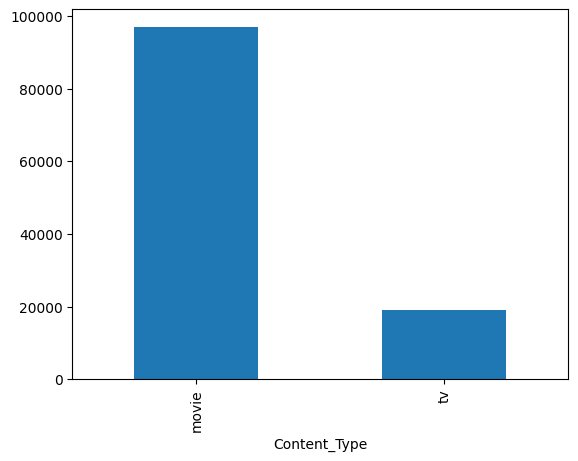

In [50]:
# Bar graph to compare Content_Type to Service_Name

streaming_clean["Content_Type"].value_counts().plot(kind='bar')

<Axes: xlabel='Service_Name', ylabel='count'>

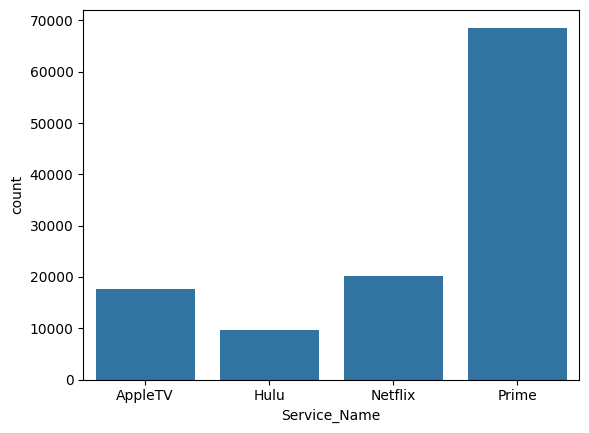

In [51]:
# Plotting which streaming platform contains the most content
sn.countplot(streaming_clean, x="Service_Name")

<Axes: xlabel='Service_Name', ylabel='count'>

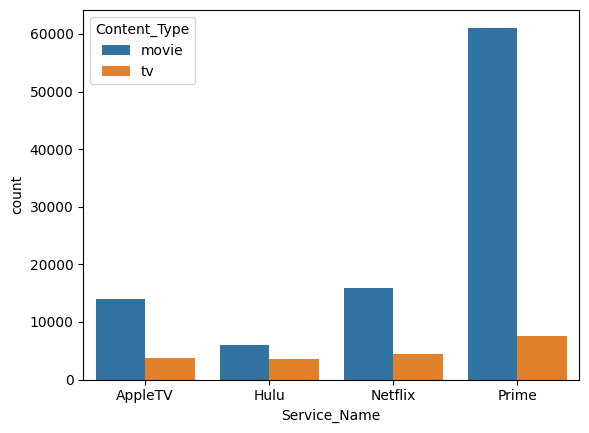

In [52]:
# Counts of the content type by streaming sesrvice
sn.countplot(streaming_clean,x="Service_Name", hue="Content_Type")